# Data Ball Z
# Regression Analysis of Beijing Multi-Site Air-Quality Data Data Set
___

# Preamble

In [2]:
# Relevant imports

import glob
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

## Data Exploration

In [2]:
# Loading in the data

# Get CSV files list from a folder
csv_files = glob.glob("./AirQuality/*.csv")

# Read each CSV file into DataFrame and concatenate into a single dataframe
df_list = [pd.read_csv(file) for file in csv_files]
air_quality_df = pd.concat(df_list, ignore_index=True)

In [3]:
# Number of samples across the 12 CSV files

print(f"Total Number of Samples = {air_quality_df.shape[0]}")

Total Number of Samples = 420768


In [4]:
# Examining the different features available

print(f"There are a total of {air_quality_df.shape[1]} columns")

print(air_quality_df.columns.values)

There are a total of 18 columns
['No' 'year' 'month' 'day' 'hour' 'PM2.5' 'PM10' 'SO2' 'NO2' 'CO' 'O3'
 'TEMP' 'PRES' 'DEWP' 'RAIN' 'wd' 'WSPM' 'station']


Although there are a total of 18 different columns in each csv file, `No` and `station` is the identifier of the sample and where the sample was recorded, so they are not features nor labels. Furthermore, `TEMP`, `PRES`, `DEWP`, `RAIN`, and `WSPM` are the quantitative labels for each sample, and `wd` is the only qualitative label. The quantitative features include `PM2.5`, `PM10`, `SO2`, `NO2`, `CO`, `O3`, `year`, `month`, `day`, and `hour`, which are the measures of different pollutants in the air at a particular day and hour. Thus, there are a total of 10 raw features.

In [5]:
# Missing Data

print(air_quality_df.isnull().sum() * 100 / air_quality_df.shape[0])

No         0.000000
year       0.000000
month      0.000000
day        0.000000
hour       0.000000
PM2.5      2.076916
PM10       1.532674
SO2        2.143937
NO2        2.879497
CO         4.919813
O3         3.155421
TEMP       0.094589
PRES       0.093401
DEWP       0.095777
RAIN       0.092688
wd         0.433018
WSPM       0.075576
station    0.000000
dtype: float64


As we can see, most of the labels are barely missing any data, with `wd` having 0.4% of its values missing. However, the features are certainly missing a decent amount of values, so they will have to be dealt with when preprocessing the data.

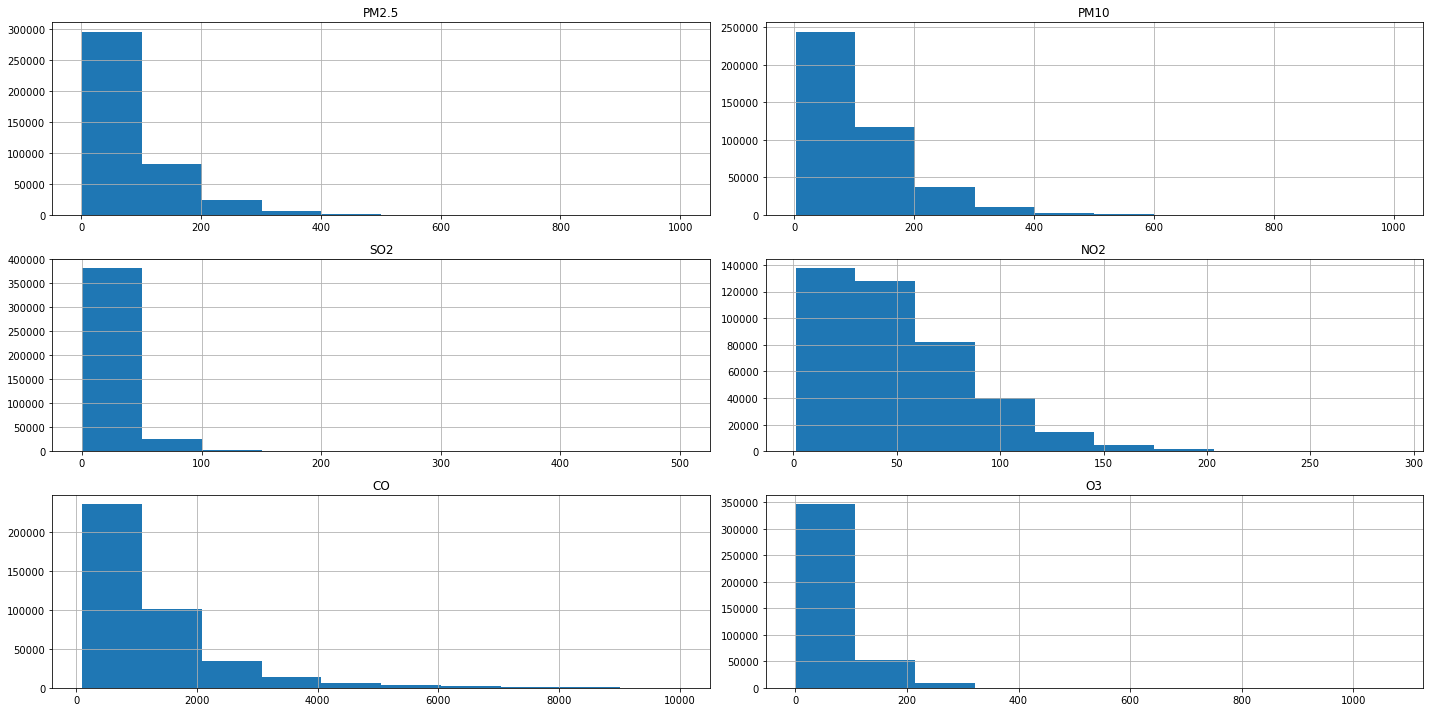

In [6]:
# Histograms of the Feature Data

air_quality_df.hist(column=["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"], figsize=(20, 10))
plt.tight_layout()
plt.show()

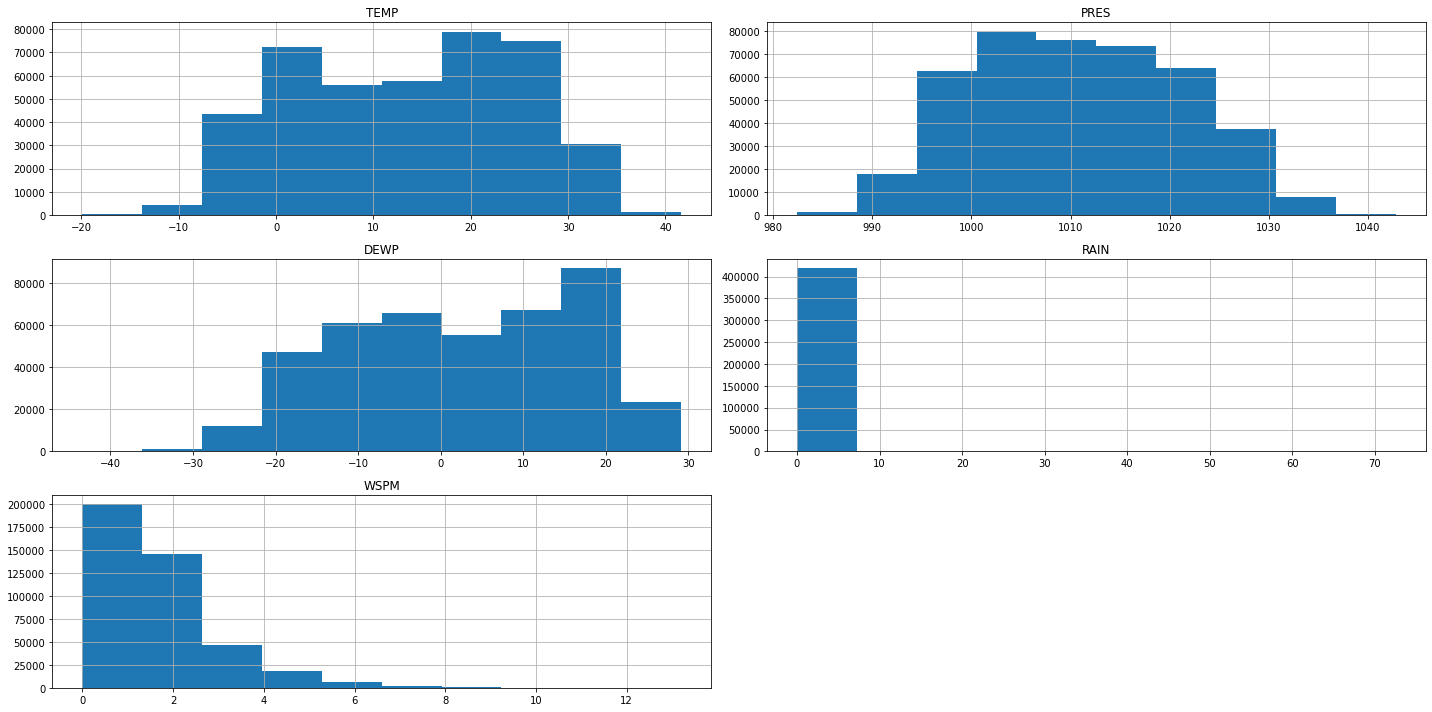

In [7]:
# Histograms of the Labels

air_quality_df.hist(column=["TEMP", "PRES", "DEWP", "RAIN", "WSPM"], figsize=(20, 10))
plt.tight_layout()
plt.show()

## Preprocessing of the Dataset

To preprocess the data, I will apply a few transformations. First, the `wd` predictor will have an integer encoding, with `N` having a value of 0, and increasing clockwise so `NNE` is 1, `NE` is 2, `ENE` is 3, and so on. Namely, any features that have missing values will be replaced by the mean of the feature. This is so that no sample has any missing values, and thus affect the performance of the model. The data will also be centered so that the intercept when conducting the regression is meaningful. Since it does not make sense for the predictors to have values of 0 (because they are concentrations of compounds in our atmosphere), the intercept would not make sense if the data was not centered. If the data was centered, then the intercept is the expected value of the labels when the predictors are set to their expected values (Goldstein). Finally, since the scales of the different features are very different, with some like `PM2.5` and `PM10` having values in the hundreds, and `CO` in the thousands, the data will be standardized. This is so those higher scaled features will not dominate the regression.

In [8]:
# Encoding wd

direction_to_int = {'N': 0, 'NNE': 1, 'NE': 2, 'ENE': 3, 'E': 4, 'ESE': 5, 'SE': 6, 'SSE': 7, 'S': 8, 'SSW': 9,
                   'SW': 10, 'WSW': 11, 'W': 12, 'WNW': 13, 'NW': 14, 'NNW': 15}

air_quality_df = air_quality_df.replace({"wd": direction_to_int})

In [9]:
# Replacing missing values with mean

cols = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','wd','WSPM']

for col in cols:
    air_quality_df[col].fillna(value=air_quality_df[col].mean(), inplace=True)
    
air_quality_df['wd'] = air_quality_df['wd'].round()

In [10]:
# Normalizing the data

cols_to_norm = ['PM2.5','PM10','SO2','NO2','CO','O3']
air_quality_df[cols_to_norm] = air_quality_df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

## Feature Learning and Extraction

Instead of working with four different variables to determine the time of each sample, the year, month, day, and hour will be combined into one `time` variable that will represent the number of hours from March 1st, 2013, which is the first day the data was recorded from. This simplifies and standardizes the time so there is a clear sequence of increasing time. Additionally, the sample number and station variables will be dropped as they are no longer needed.

In [11]:
date_format_str = '%d/%m/%Y %H'
start_date = '01/03/2013 0'

def getHours(row):
    year = row['year']
    month = row['month']
    day = row['day']
    hour = row['hour']
    
    end_date = f"{day}/{month}/{year} {hour}"
    start = datetime.strptime(start_date, date_format_str)
    end = datetime.strptime(end_date, date_format_str)
    diff = end - start
    
    hours = diff.total_seconds() / 3600
    return hours

# Creating a new time column
air_quality_df['time'] = air_quality_df.apply(lambda row: getHours(row), axis=1)

# Normalizing Time
air_quality_df['time'] = (air_quality_df['time'] - air_quality_df['time'].mean()) / air_quality_df['time'].std()

In [12]:
# Dropping the year, month, day, hour, No, and station columns

air_quality_df = air_quality_df.drop(['year', 'month', 'day', 'hour', 'No', 'station'], axis=1)

# Place the new time in the front of the df

time_column = air_quality_df.pop('time')
air_quality_df.insert(0, 'time', time_column)

air_quality_df

,time,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,-1.731999,-0.922664,-0.950983,-5.057060e-01,-4.878784e-13,-3.807768e-01,5.492730e-01,0.1,1021.1,-18.6,0.0,14.0,4.4
1,-1.731901,-0.922664,-0.983926,-5.057060e-01,-4.878784e-13,-3.807768e-01,5.492730e-01,-0.3,1021.5,-19.0,0.0,14.0,4.0
2,-1.731802,-0.935167,-0.950983,8.658982e-14,-4.878784e-13,-4.691720e-01,-9.634549e-02,-0.7,1021.5,-19.8,0.0,13.0,4.6
3,-1.731703,-0.922664,-0.929021,-4.590146e-01,-4.878784e-13,3.205749e-13,-8.537652e-14,-1.0,1022.7,-21.2,0.0,12.0,2.8
4,-1.731604,-0.935167,-0.961964,-5.057060e-01,-4.878784e-13,-5.575672e-01,2.802653e-01,-1.3,1023.0,-21.4,0.0,13.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,1.731604,-0.660094,-0.358009,-3.656320e-01,1.194779e+00,-3.807768e-01,-7.419640e-01,10.3,1014.2,-12.4,0.0,12.0,1.8
420764,1.731703,-0.410027,-0.544686,5.458987e-02,1.021461e+00,-1.155913e-01,-6.881625e-01,9.8,1014.5,-9.9,0.0,14.0,1.5
420765,1.731802,-0.772624,-0.841173,-5.523973e-01,-5.961728e-01,-6.459624e-01,1.188607e-01,9.1,1014.6,-12.7,0.0,2.0,1.7
420766,1.731901,-0.772624,-0.929021,-3.189407e-01,-5.095138e-01,-6.459624e-01,2.919144e-02,7.1,1015.2,-13.2,0.0,13.0,1.8


## Processing Dataset Using Ridge Regression

In this portion, we will train a Ridge Regression linear model. To determine the value of lambda that will be used in the model, we use a K-Fold cross validation, where `k = 10`. Furthermore, it will be a repeated K-Fold cross validation so that there is less variance with the splits. The lambda that provides the lowest test error, which will be calculated as the mean squared error, will be used for the final model.

In [13]:
# Predictor Variables
X = air_quality_df[["time", "PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]]

# Labels
Y = air_quality_df[["TEMP", "PRES", "DEWP", "RAIN", "wd", "WSPM"]]

In [41]:
# Generating the 10 fold splits

alphas = np.arange(0, 50, 1)
cv = RepeatedKFold(n_splits=10, n_repeats=3)

alpha_error = {}

# Fitting the Model across the splits
for train_index, test_index in cv.split(X):
    for alpha in alphas:
        ridge_model = Ridge(alpha)
        ridge_model.fit(X.iloc[train_index], Y.iloc[train_index])
        
        y = ridge_model.predict(X.iloc[test_index])
        
        mse = mean_squared_error(Y.iloc[test_index], y)
        
        if alpha not in alpha_error:
            alpha_error[alpha] = 0
            
        alpha_error[alpha] += mse

for alpha in alpha_error:
    alpha_error[alpha] /= cv.get_n_splits(X, Y)

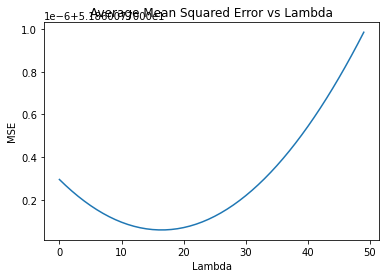

In [46]:
# Determining the best value of lambda
plt.plot(alpha_error.keys(), alpha_error.values())
plt.title("Average Mean Squared Error vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.show()

First, the dataframe was split into the predictor variables and the labels. After the split, the repeated k fold cross validation was run and repeated 3 times to minimize variance, as stated before. For each value of lambda (denoted `alpha` because `lambda` is a reserved keyword in Python for lambda functions), the mean squared error was recorded for each k-fold split and summed up. The average mean squared error of the test data was computed for each value of lambda. Plotting these averages shows that the best value to pick occurs somewhere between 15 and 18. And so, after determining this specific lambda, it will be trained on the entire dataset to finalize our model.

In [48]:
# Finding the specific value of Lambda

lmbda = min(alpha_error, key=alpha_error.get)

print(f"The optimal lambda is {lmbda}")

The optimal lambda is 16


In [49]:
# Training the model with the final lambda value on the entire dataset

final_ridge_model = Ridge(lmbda)
final_ridge_model.fit(X, Y)

Ridge(alpha=16)

In [51]:
# Running the model against the data

y_final = final_ridge_model.predict(X)

In [58]:
final_mse = mean_squared_error(Y, y_final)

r_squared = final_ridge_model.score(X, Y)

print(f"The mean squared error on the final model is {final_mse:.3f} and has a coefficient of determination of {r_squared:.3f}")

The mean squared error on the final model is 51.858 and has a coefficient of determination of 0.212


With such a low coefficient of determination, this implies that the data is not very linear. A linear model is most likely not appropriate to model the air quality data. This could also mean that there is not a strong correlation between the air pollutants and meteorological data.

In [75]:
raw_aq_df = pd.concat(df_list, ignore_index=True)

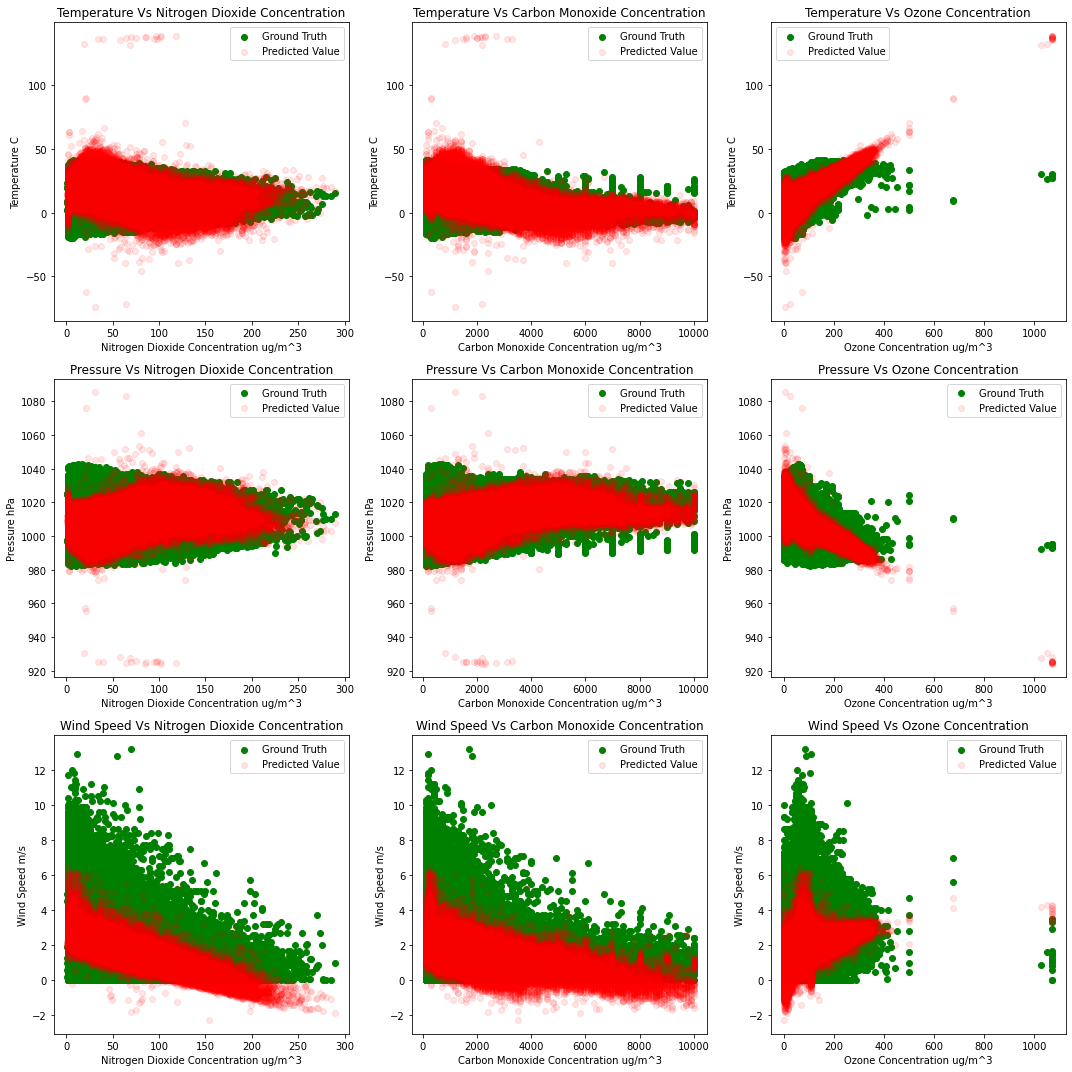

In [80]:
# Some plots of the predicted vs actual data

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# temp vs no2
ax1 = fig.add_subplot(331)
# temp vs co
ax2 = fig.add_subplot(332)
# temp vs o3
ax3 = fig.add_subplot(333)
# pres vs no2
ax4 = fig.add_subplot(334)
# pres vs co
ax5 = fig.add_subplot(335)
# pres vs o3
ax6 = fig.add_subplot(336)
# wspm vs no2
ax7 = fig.add_subplot(337)
# wspm vs co
ax8 = fig.add_subplot(338)
# wspm vs 03
ax9 = fig.add_subplot(339)

ax1.scatter(raw_aq_df['NO2'], raw_aq_df['TEMP'], c='green', label='Ground Truth')
ax1.scatter(raw_aq_df['NO2'], y_final[:, 0], c='red', label='Predicted Value', alpha=0.1)
ax1.legend()
ax1.set_title('Temperature Vs Nitrogen Dioxide Concentration')
ax1.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax1.set_ylabel('Temperature C')

ax2.scatter(raw_aq_df['CO'], raw_aq_df['TEMP'], c='green', label='Ground Truth')
ax2.scatter(raw_aq_df['CO'], y_final[:, 0], c='red', label='Predicted Value', alpha=0.1)
ax2.legend()
ax2.set_title('Temperature Vs Carbon Monoxide Concentration')
ax2.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax2.set_ylabel('Temperature C')

ax3.scatter(raw_aq_df['O3'], raw_aq_df['TEMP'], c='green', label='Ground Truth')
ax3.scatter(raw_aq_df['O3'], y_final[:, 0], c='red', label='Predicted Value', alpha=0.1)
ax3.legend()
ax3.set_title('Temperature Vs Ozone Concentration')
ax3.set_xlabel('Ozone Concentration ug/m^3')
ax3.set_ylabel('Temperature C')

ax4.scatter(raw_aq_df['NO2'], raw_aq_df['PRES'], c='green', label='Ground Truth')
ax4.scatter(raw_aq_df['NO2'], y_final[:, 1], c='red', label='Predicted Value', alpha=0.1)
ax4.legend()
ax4.set_title('Pressure Vs Nitrogen Dioxide Concentration')
ax4.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax4.set_ylabel('Pressure hPa')

ax5.scatter(raw_aq_df['CO'], raw_aq_df['PRES'], c='green', label='Ground Truth')
ax5.scatter(raw_aq_df['CO'], y_final[:, 1], c='red', label='Predicted Value', alpha=0.1)
ax5.legend()
ax5.set_title('Pressure Vs Carbon Monoxide Concentration')
ax5.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax5.set_ylabel('Pressure hPa')

ax6.scatter(raw_aq_df['O3'], raw_aq_df['PRES'], c='green', label='Ground Truth')
ax6.scatter(raw_aq_df['O3'], y_final[:, 1], c='red', label='Predicted Value', alpha=0.1)
ax6.legend()
ax6.set_title('Pressure Vs Ozone Concentration')
ax6.set_xlabel('Ozone Concentration ug/m^3')
ax6.set_ylabel('Pressure hPa')

ax7.scatter(raw_aq_df['NO2'], raw_aq_df['WSPM'], c='green', label='Ground Truth')
ax7.scatter(raw_aq_df['NO2'], y_final[:, 5], c='red', label='Predicted Value', alpha=0.1)
ax7.legend()
ax7.set_title('Wind Speed Vs Nitrogen Dioxide Concentration')
ax7.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax7.set_ylabel('Wind Speed m/s')

ax8.scatter(raw_aq_df['CO'], raw_aq_df['WSPM'], c='green', label='Ground Truth')
ax8.scatter(raw_aq_df['CO'], y_final[:, 5], c='red', label='Predicted Value', alpha=0.1)
ax8.legend()
ax8.set_title('Wind Speed Vs Carbon Monoxide Concentration')
ax8.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax8.set_ylabel('Wind Speed m/s')

ax9.scatter(raw_aq_df['O3'], raw_aq_df['WSPM'], c='green', label='Ground Truth')
ax9.scatter(raw_aq_df['O3'], y_final[:, 5], c='red', label='Predicted Value', alpha=0.1)
ax9.legend()
ax9.set_title('Wind Speed Vs Ozone Concentration')
ax9.set_xlabel('Ozone Concentration ug/m^3')
ax9.set_ylabel('Wind Speed m/s')

plt.tight_layout()
plt.show()

As shown by the different plots, for some plots, the model fits the data well. However, for a good amount of the plots, like Wind Speed Vs Ozone, the data is clearly not linear, and so the model does not fit the data wekk at all. This was made evident by the low $R^2$ value. Furthermore, some predictions do not make sense. Some of the plots, specifically those for wind speed, predict negative speeds. Speed is a nonnegative quantitity, so these predictions have no meaning.

## Processing Dataset Using Lasso Regression

In this portion, we will train a Lasso Linear Regression model. Similar to Ridge Regression, the tuning parameter lambda will be determined using a repeated K-Fold cross validation, where `k = 10`. The lambda that provides the lowest test error, which will be calculated as the mean squared error, will be used for the final model.

In [103]:
# Generating the 10 fold splits
cv_lasso = RepeatedKFold(n_splits=10, n_repeats=3)
alphas_lasso = np.arange(0.01, 0.11, 0.01)

alpha_error_lasso = {}

# Fitting the Model across the splits
for train_index, test_index in cv_lasso.split(X):
    for alpha in alphas_lasso:
        lasso_model = Lasso(alpha, precompute=True)
        lasso_model.fit(X.iloc[train_index], Y.iloc[train_index])
        
        y = lasso_model.predict(X.iloc[test_index])
        
        mse = mean_squared_error(Y.iloc[test_index], y)
        
        if alpha not in alpha_error_lasso:
            alpha_error_lasso[alpha] = 0
            
        alpha_error_lasso[alpha] += mse

for alpha in alpha_error_lasso:
    alpha_error_lasso[alpha] /= cv_lasso.get_n_splits(X, Y)

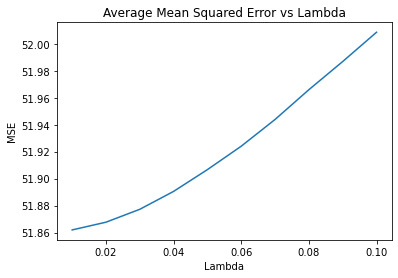

In [104]:
# Determining the best value of lambda
plt.plot(alpha_error_lasso.keys(), alpha_error_lasso.values())
plt.title("Average Mean Squared Error vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.show()

The same procedure that was done with Ridge Regression was repeated for Lasso; a repeated K-Fold cross validation was done with 3 repeats and `k = 10`, and the average mean squared error was computed for each lambda across the different splits. Plotting these averages shows a very different image from Ridge Regression. The plot for the MSE and Lambda is strictly increasing, so the minimal value of lambda will be the one we started with, namely, 0.01. Furthermore, the magnitude is much lower, around three orders of magnitudes lower. Thus, the lambda value of 0.01 will be used and trained against the entire dataset. 

In [105]:
# Training the model with the final lambda value on the entire dataset

final_lasso_model = Lasso(0.01)
final_lasso_model.fit(X, Y)

Lasso(alpha=0.01)

In [106]:
# Running the model against the data

y_final_lasso = final_lasso_model.predict(X)

In [107]:
final_mse_lasso = mean_squared_error(Y, y_final_lasso)

r_squared_lasso = final_lasso_model.score(X, Y)

print(f"The mean squared error on the final model is {final_mse_lasso:.3f} and has a coefficient of determination of {r_squared_lasso:.3f}")

The mean squared error on the final model is 51.860 and has a coefficient of determination of 0.211


Unsurprisingly, the Lasso Regression model also produces a low coefficient of determination and similar mean squared error to the Ridge Regression. As shown previously, many of the variables do not correlate with each other linearly, so it makes sense that these models will perform poorly.

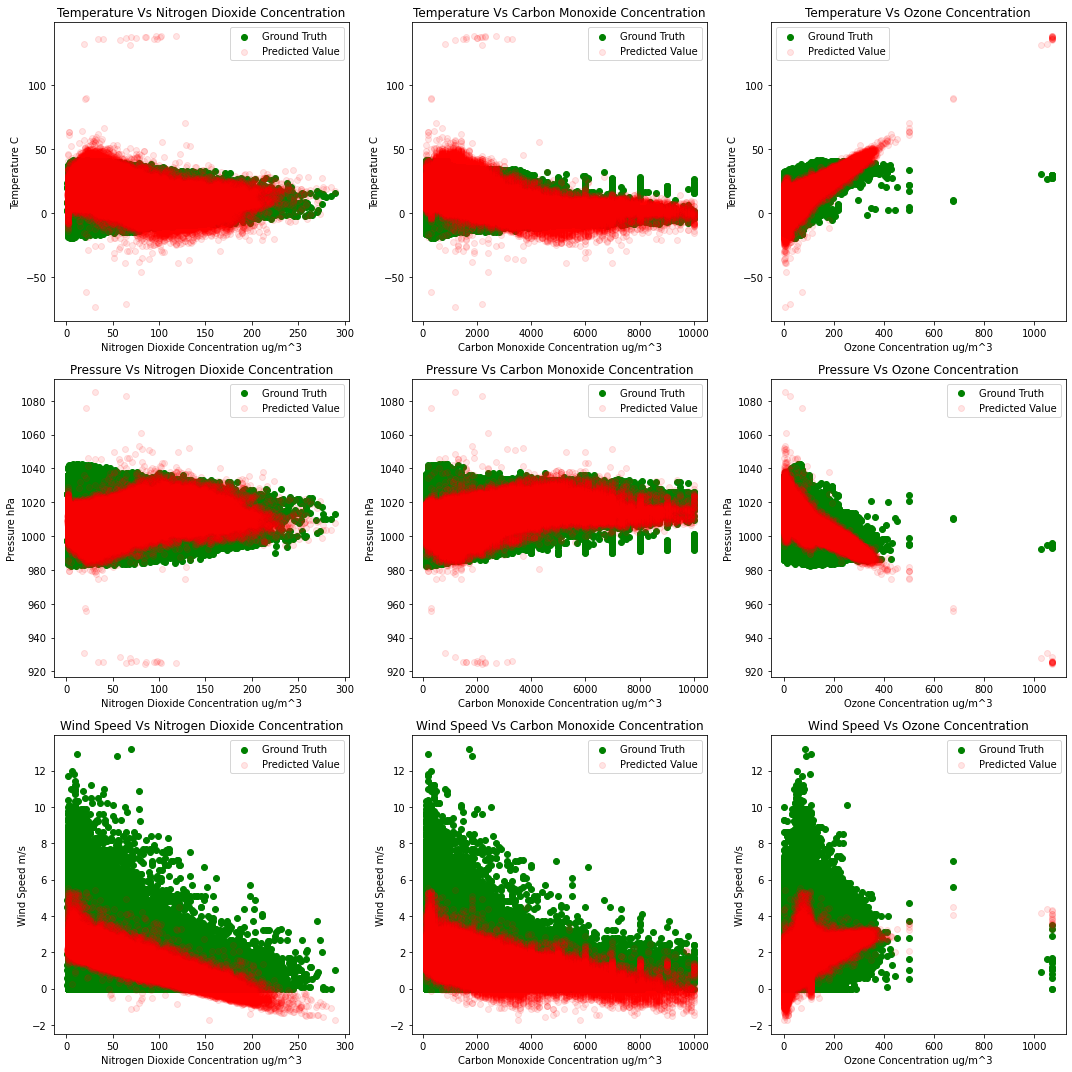

In [108]:
# Some plots of the predicted vs actual data

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# temp vs no2
ax1 = fig.add_subplot(331)
# temp vs co
ax2 = fig.add_subplot(332)
# temp vs o3
ax3 = fig.add_subplot(333)
# pres vs no2
ax4 = fig.add_subplot(334)
# pres vs co
ax5 = fig.add_subplot(335)
# pres vs o3
ax6 = fig.add_subplot(336)
# wspm vs no2
ax7 = fig.add_subplot(337)
# wspm vs co
ax8 = fig.add_subplot(338)
# wspm vs 03
ax9 = fig.add_subplot(339)

ax1.scatter(raw_aq_df['NO2'], raw_aq_df['TEMP'], c='green', label='Ground Truth')
ax1.scatter(raw_aq_df['NO2'], y_final_lasso[:, 0], c='red', label='Predicted Value', alpha=0.1)
ax1.legend()
ax1.set_title('Temperature Vs Nitrogen Dioxide Concentration')
ax1.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax1.set_ylabel('Temperature C')

ax2.scatter(raw_aq_df['CO'], raw_aq_df['TEMP'], c='green', label='Ground Truth')
ax2.scatter(raw_aq_df['CO'], y_final_lasso[:, 0], c='red', label='Predicted Value', alpha=0.1)
ax2.legend()
ax2.set_title('Temperature Vs Carbon Monoxide Concentration')
ax2.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax2.set_ylabel('Temperature C')

ax3.scatter(raw_aq_df['O3'], raw_aq_df['TEMP'], c='green', label='Ground Truth')
ax3.scatter(raw_aq_df['O3'], y_final_lasso[:, 0], c='red', label='Predicted Value', alpha=0.1)
ax3.legend()
ax3.set_title('Temperature Vs Ozone Concentration')
ax3.set_xlabel('Ozone Concentration ug/m^3')
ax3.set_ylabel('Temperature C')

ax4.scatter(raw_aq_df['NO2'], raw_aq_df['PRES'], c='green', label='Ground Truth')
ax4.scatter(raw_aq_df['NO2'], y_final_lasso[:, 1], c='red', label='Predicted Value', alpha=0.1)
ax4.legend()
ax4.set_title('Pressure Vs Nitrogen Dioxide Concentration')
ax4.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax4.set_ylabel('Pressure hPa')

ax5.scatter(raw_aq_df['CO'], raw_aq_df['PRES'], c='green', label='Ground Truth')
ax5.scatter(raw_aq_df['CO'], y_final_lasso[:, 1], c='red', label='Predicted Value', alpha=0.1)
ax5.legend()
ax5.set_title('Pressure Vs Carbon Monoxide Concentration')
ax5.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax5.set_ylabel('Pressure hPa')

ax6.scatter(raw_aq_df['O3'], raw_aq_df['PRES'], c='green', label='Ground Truth')
ax6.scatter(raw_aq_df['O3'], y_final_lasso[:, 1], c='red', label='Predicted Value', alpha=0.1)
ax6.legend()
ax6.set_title('Pressure Vs Ozone Concentration')
ax6.set_xlabel('Ozone Concentration ug/m^3')
ax6.set_ylabel('Pressure hPa')

ax7.scatter(raw_aq_df['NO2'], raw_aq_df['WSPM'], c='green', label='Ground Truth')
ax7.scatter(raw_aq_df['NO2'], y_final_lasso[:, 5], c='red', label='Predicted Value', alpha=0.1)
ax7.legend()
ax7.set_title('Wind Speed Vs Nitrogen Dioxide Concentration')
ax7.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax7.set_ylabel('Wind Speed m/s')

ax8.scatter(raw_aq_df['CO'], raw_aq_df['WSPM'], c='green', label='Ground Truth')
ax8.scatter(raw_aq_df['CO'], y_final_lasso[:, 5], c='red', label='Predicted Value', alpha=0.1)
ax8.legend()
ax8.set_title('Wind Speed Vs Carbon Monoxide Concentration')
ax8.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax8.set_ylabel('Wind Speed m/s')

ax9.scatter(raw_aq_df['O3'], raw_aq_df['WSPM'], c='green', label='Ground Truth')
ax9.scatter(raw_aq_df['O3'], y_final_lasso[:, 5], c='red', label='Predicted Value', alpha=0.1)
ax9.legend()
ax9.set_title('Wind Speed Vs Ozone Concentration')
ax9.set_xlabel('Ozone Concentration ug/m^3')
ax9.set_ylabel('Wind Speed m/s')

plt.tight_layout()
plt.show()

As seen by these plots, the Lasso Regression model performed nearly identically to Ridge Regression.

## Comparison of the Two Methods

In terms of computational complexity, the Lasso Regression took significantly longer to fit on the data. As a result, a smaller range of lambda values were used during cross validation, otherwise the computation would have taken many hours or perhaps days (at least on our machines). This is most likely due to the fact that Ridge Regression has a closed form solution, but Lasso does not, so computing the solution for Lasso is a harder computational challenge.

Based on the coefficients of determination and mean squared error for the two models, they performed very similarly for their chosen values of lambda. The Ridge Regression with a lambda of 16 had a mean squared error of 51.858 and a coefficient of determination of 0.212, whereas the Lasso Regression with a lambda of 0.01 had a mean squared error of 51.860 and a coefficient of determination of 0.211. Ridge Regression had a slightly lower error and a slightly higher coefficient of determination.

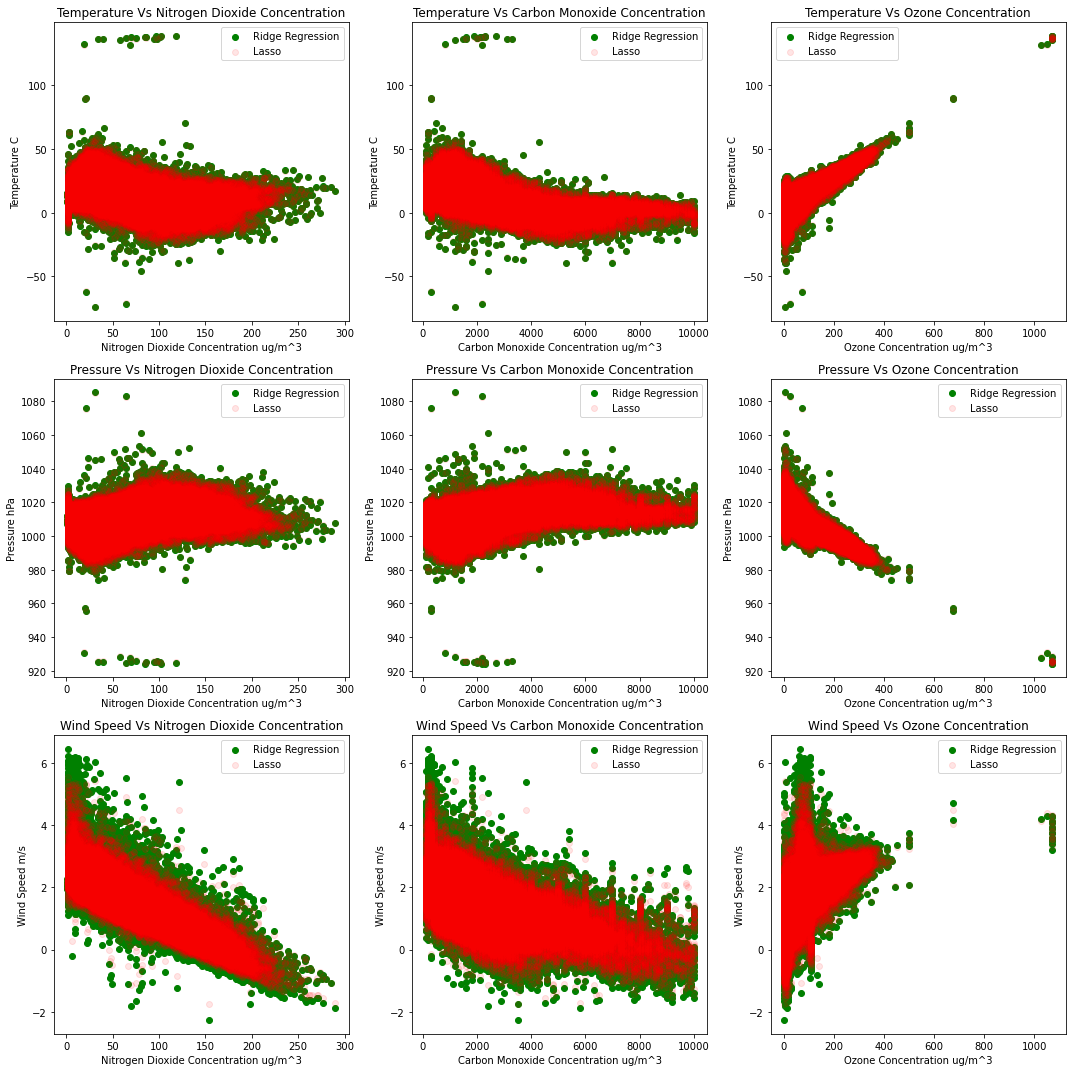

In [109]:
# Some plots of the predicted vs actual data

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# temp vs no2
ax1 = fig.add_subplot(331)
# temp vs co
ax2 = fig.add_subplot(332)
# temp vs o3
ax3 = fig.add_subplot(333)
# pres vs no2
ax4 = fig.add_subplot(334)
# pres vs co
ax5 = fig.add_subplot(335)
# pres vs o3
ax6 = fig.add_subplot(336)
# wspm vs no2
ax7 = fig.add_subplot(337)
# wspm vs co
ax8 = fig.add_subplot(338)
# wspm vs 03
ax9 = fig.add_subplot(339)

ax1.scatter(raw_aq_df['NO2'], y_final[:, 0], c='green', label='Ridge Regression')
ax1.scatter(raw_aq_df['NO2'], y_final_lasso[:, 0], c='red', label='Lasso', alpha=0.1)
ax1.legend()
ax1.set_title('Temperature Vs Nitrogen Dioxide Concentration')
ax1.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax1.set_ylabel('Temperature C')

ax2.scatter(raw_aq_df['CO'], y_final[:, 0], c='green', label='Ridge Regression')
ax2.scatter(raw_aq_df['CO'], y_final_lasso[:, 0], c='red', label='Lasso', alpha=0.1)
ax2.legend()
ax2.set_title('Temperature Vs Carbon Monoxide Concentration')
ax2.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax2.set_ylabel('Temperature C')

ax3.scatter(raw_aq_df['O3'], y_final[:, 0], c='green', label='Ridge Regression')
ax3.scatter(raw_aq_df['O3'], y_final_lasso[:, 0], c='red', label='Lasso', alpha=0.1)
ax3.legend()
ax3.set_title('Temperature Vs Ozone Concentration')
ax3.set_xlabel('Ozone Concentration ug/m^3')
ax3.set_ylabel('Temperature C')

ax4.scatter(raw_aq_df['NO2'], y_final[:, 1], c='green', label='Ridge Regression')
ax4.scatter(raw_aq_df['NO2'], y_final_lasso[:, 1], c='red', label='Lasso', alpha=0.1)
ax4.legend()
ax4.set_title('Pressure Vs Nitrogen Dioxide Concentration')
ax4.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax4.set_ylabel('Pressure hPa')

ax5.scatter(raw_aq_df['CO'], y_final[:, 1], c='green', label='Ridge Regression')
ax5.scatter(raw_aq_df['CO'], y_final_lasso[:, 1], c='red', label='Lasso', alpha=0.1)
ax5.legend()
ax5.set_title('Pressure Vs Carbon Monoxide Concentration')
ax5.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax5.set_ylabel('Pressure hPa')

ax6.scatter(raw_aq_df['O3'], y_final[:, 1], c='green', label='Ridge Regression')
ax6.scatter(raw_aq_df['O3'], y_final_lasso[:, 1], c='red', label='Lasso', alpha=0.1)
ax6.legend()
ax6.set_title('Pressure Vs Ozone Concentration')
ax6.set_xlabel('Ozone Concentration ug/m^3')
ax6.set_ylabel('Pressure hPa')

ax7.scatter(raw_aq_df['NO2'], y_final[:, 5], c='green', label='Ridge Regression')
ax7.scatter(raw_aq_df['NO2'], y_final_lasso[:, 5], c='red', label='Lasso', alpha=0.1)
ax7.legend()
ax7.set_title('Wind Speed Vs Nitrogen Dioxide Concentration')
ax7.set_xlabel('Nitrogen Dioxide Concentration ug/m^3')
ax7.set_ylabel('Wind Speed m/s')

ax8.scatter(raw_aq_df['CO'], y_final[:, 5], c='green', label='Ridge Regression')
ax8.scatter(raw_aq_df['CO'], y_final_lasso[:, 5], c='red', label='Lasso', alpha=0.1)
ax8.legend()
ax8.set_title('Wind Speed Vs Carbon Monoxide Concentration')
ax8.set_xlabel('Carbon Monoxide Concentration ug/m^3')
ax8.set_ylabel('Wind Speed m/s')

ax9.scatter(raw_aq_df['O3'], y_final[:, 5], c='green', label='Ridge Regression')
ax9.scatter(raw_aq_df['O3'], y_final_lasso[:, 5], c='red', label='Lasso', alpha=0.1)
ax9.legend()
ax9.set_title('Wind Speed Vs Ozone Concentration')
ax9.set_xlabel('Ozone Concentration ug/m^3')
ax9.set_ylabel('Wind Speed m/s')

plt.tight_layout()
plt.show()

When overlaying the different plots on top of each other, we can see that Lasso has a lot less spread than Ridge Regression. The predicted values for Ridge Regression tend to occupy a greater range and include many more outliers and stragglers. The reason for this is most likely due to the L1 regularizer forcing some of the predictors to have no contribution.

In [111]:
mse_methods = mean_squared_error(y_final, y_final_lasso)

print(f"The mean squared error between the two methods is {mse_methods:.3f}")

The mean squared error between the two methods is 0.002


The difference between the two methods highlights how similarly the two methods performed. However, even though they performed similarly, the lower variability of Lasso leads me to recommend this method over Ridge Regression. This being said, neither are good models, and probably should not be used in an actual production system.

## Ethical Issues

The data that was collected for this dataset was through 12 nationally controlled air-quality monitoring sites for the air quality variables, and from the nearest weather station of each of those sites for the meteorological variables (Zhang et al.). Thus, there are not any concerns regarding the ethics of collecting this data. They were merely collected through sensors measuring pollutants in the air, and from a weather station giving information about pressure, precipitation, etc. The task itself also is not very questionable from an ethics standpoint either, as all we are doing is predicting how the different pollutants in the air may be correlated to the weather. However, one could argue that corporations could use this information to determine how much they could affect the air quality before it nontrivially affects the weather, and thereby push to those limits to produce as much as they can without arousing suspicion. This could be unethical as companies can use the information to learn how much they can harm the environment for their own gain.

## Bibliography 

Goldstein, Neal D. The Why and When of Centering Continuous Predictors in Regression Modeling, 19 Nov. 2015, https://www.goldsteinepi.com/blog/thewhyandwhenofcenteringcontinuouspredictorsinregressionmodeling/index.html. 

scikit-learn developers. “Sklearn.linear_model.Lasso.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html. Accessed 17 Dec. 2022.

---. “Sklearn.linear_model.Ridge.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.

---. “Sklearn.metrics.mean_squared_error — Scikit-Learn 0.24.2 Documentation.” Scikit-Learn.org, scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html.

---. “Sklearn.model_selection.RepeatedKFold.” Scikit-Learn, scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html. Accessed 17 Dec. 2022.

Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457 (2017).